In [1]:
# ================================
# Step 1: Setup Environment
# ================================
!pip install -q ultralytics
# Mount Google Drive for data persistence
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True

In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA Available: False
CUDA Device Count: 0
CUDA Device Name: None


In [10]:
# ================================
# Step 2: Upload and Extract Dataset
# ================================
import json
import os
import cv2

# Define paths
data_dir = "/content/PigDataset"
os.makedirs(data_dir, exist_ok=True)
images_dir = os.path.join(data_dir, "images")
labels_dir = os.path.join(data_dir, "labels")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Upload the outputs.json and video file manually or through Drive
outputs_path = os.path.join(data_dir, "/content/drive/MyDrive/EdinburghPig/000009//output.json")
video_path = os.path.join(data_dir, "/content/drive/MyDrive/EdinburghPig/000009/color.mp4")

In [21]:
# ================================
# Step 3: Extract Frames from Video
# ================================
def extract_frames(video_path, output_folder, frame_step=3):
    cap = cv2.VideoCapture(video_path)
    count = 0
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save every third frame starting from the first
        if frame_count % frame_step == 0:
            frame_name = f"frame_{count:04d}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)
            count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {count} frames from video.")

# Use the modified function
extract_frames(video_path, images_dir, frame_step=3)

Extracted 600 frames from video.


In [26]:
import os
import json
import cv2

# ================================
# Enhanced Function: Parse Annotations (Ensure 600 Frames)
# ================================
def parse_annotations(outputs_path, images_dir, labels_dir):
    with open(outputs_path, 'r') as f:
        data = json.load(f)

    total_pigs = len(data['objects'])
    print(f"Total pigs found: {total_pigs}")

    frame_count = 0
    label_count = 0
    last_annotations = {}  # To store the last valid annotations for each pig

    # Collect last known annotations for each pig
    for obj in data['objects']:
        pig_id = int(obj['id'])  # Ensure ID is an integer
        print(f"Processing Pig ID: {pig_id}")

        for frame in obj['frames']:
            frame_number = frame['frameNumber']
            bbox = frame['bbox']
            x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']

            # Store the last valid annotation for this pig
            last_annotations[pig_id] = (x, y, w, h, frame_number)

    # Ensure the frame range is exactly 600
    full_frame_range = range(0, 600)

    # Process each frame in the range of 600
    for frame_number in full_frame_range:
        for pig_id, (x, y, w, h, last_frame) in last_annotations.items():
            # If the frame number is within the last known frames, use it
            if frame_number <= last_frame:
                for frame in data['objects'][pig_id]['frames']:
                    if frame['frameNumber'] == frame_number:
                        bbox = frame['bbox']
                        x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
                        last_annotations[pig_id] = (x, y, w, h, frame_number)
                        break
            else:
                # Use the last known annotation (fill missing frames)
                x, y, w, h = last_annotations[pig_id][:4]

            # Path of the frame image
            img_path = os.path.join(images_dir, f"frame_{frame_number:04d}.jpg")
            if not os.path.exists(img_path):
                print(f"Frame {frame_number} does not exist. Skipping.")
                continue

            # Read image to get dimensions
            img = cv2.imread(img_path)
            if img is None:
                print(f"Frame {frame_number} is missing. Skipping.")
                continue
            img_h, img_w, _ = img.shape

            # Normalize bbox coordinates (YOLO format)
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            norm_w = w / img_w
            norm_h = h / img_h

            # Save label file (using 'a' to allow multiple pigs in one frame)
            label_path = os.path.join(labels_dir, f"frame_{frame_number:04d}.txt")
            with open(label_path, 'a') as label_file:
                label_file.write(f"{pig_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")
                label_count += 1

            frame_count += 1

    print("\n==============================")
    print(f"Annotation parsing completed.")
    print(f"Total Frames Processed: {frame_count} (Expected: 600)")
    print(f"Total Labels Created: {label_count}")
    print(f"Annotations saved in {labels_dir}.")



# Run the optimized function with debugging
parse_annotations(outputs_path, images_dir, labels_dir)


Total pigs found: 8
Processing Pig ID: 0
Processing Pig ID: 7
Processing Pig ID: 1
Processing Pig ID: 4
Processing Pig ID: 2
Processing Pig ID: 5
Processing Pig ID: 6
Processing Pig ID: 3

Annotation parsing completed.
Total Frames Processed: 4800 (Expected: 600)
Total Labels Created: 4800
Annotations saved in /content/PigDataset/labels.


In [29]:
! ls -1 /content/PigDataset/images | wc -l

600


In [30]:
! ls -1 /content/PigDataset/labels/ | wc -l

600


In [31]:
# ! rm -rf /content/PigDataset/images/*

In [32]:
# ! rm -rf /content/PigDataset/labels/*

In [33]:
import os

# Define paths
data_dir = "/content/PigDataset"

# Create a YAML configuration for YOLO training
dataset_yaml = f"""path: {data_dir}
train: images  # Use all images in 'images' directory for training
val: images    # Use the same for validation (you can split later)
test: images   # Use the same for testing (optional)
nc: 8           # Number of classes (8 pigs, IDs 0-7)
names:
  0: pig_0
  1: pig_1
  2: pig_2
  3: pig_3
  4: pig_4
  5: pig_5
  6: pig_6
  7: pig_7
"""

# Save this YAML file in the data directory
yaml_path = os.path.join(data_dir, "pig_dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(f"Dataset YAML file created at: {yaml_path}")


Dataset YAML file created at: /content/PigDataset/pig_dataset.yaml


In [ ]:
from ultralytics import YOLO
# Load the YOLOv9 model (YOLOv8 latest but effectively YOLOv9)
model = YOLO("yolov9c.pt")  # Using the nano model (fast) - change to 'yolov8s.pt' for better accuracy

# Start training
model.train(
    data=yaml_path,        # Path to the custom dataset YAML file
    epochs=1,             # Number of training epochs
    imgsz=640,             # Image size (adjust for better accuracy)
    batch=4,              # Batch size (adjust based on GPU memory)
    project="/content/YoloRuns",  # Save runs to Google Drive
    name="pig_yolo_v9_test_1",    # Custom name for the run
    workers=4,             # Number of workers (adjust for speed)
    device='cpu'               # Use GPU (CUDA)
)


Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/PigDataset/pig_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pig_yolo_v9_test_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

  8                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPELAN         [512, 512, 256]               
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1   3119616  ultralytics.nn.modules.block.RepNCSPELAN4    [1024, 512, 512, 256, 1]      
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    912640  ultralytics.nn.modules.block.RepNCSPELAN4    [1024, 256, 256, 128, 1]      
 16                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256,

train: Scanning /content/PigDataset/labels... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<00:00, 1765.54it/s]

train: New cache created: /content/PigDataset/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2204.9±726.4 MB/s, size: 317.4 KB)


val: Scanning /content/PigDataset/labels.cache... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/YoloRuns/pig_yolo_v9_test_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/YoloRuns/pig_yolo_v9_test_1
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      3.239      4.975      2.959         36        640:   1%|          | 1/150 [00:42<1:45:54, 42.65s/it]

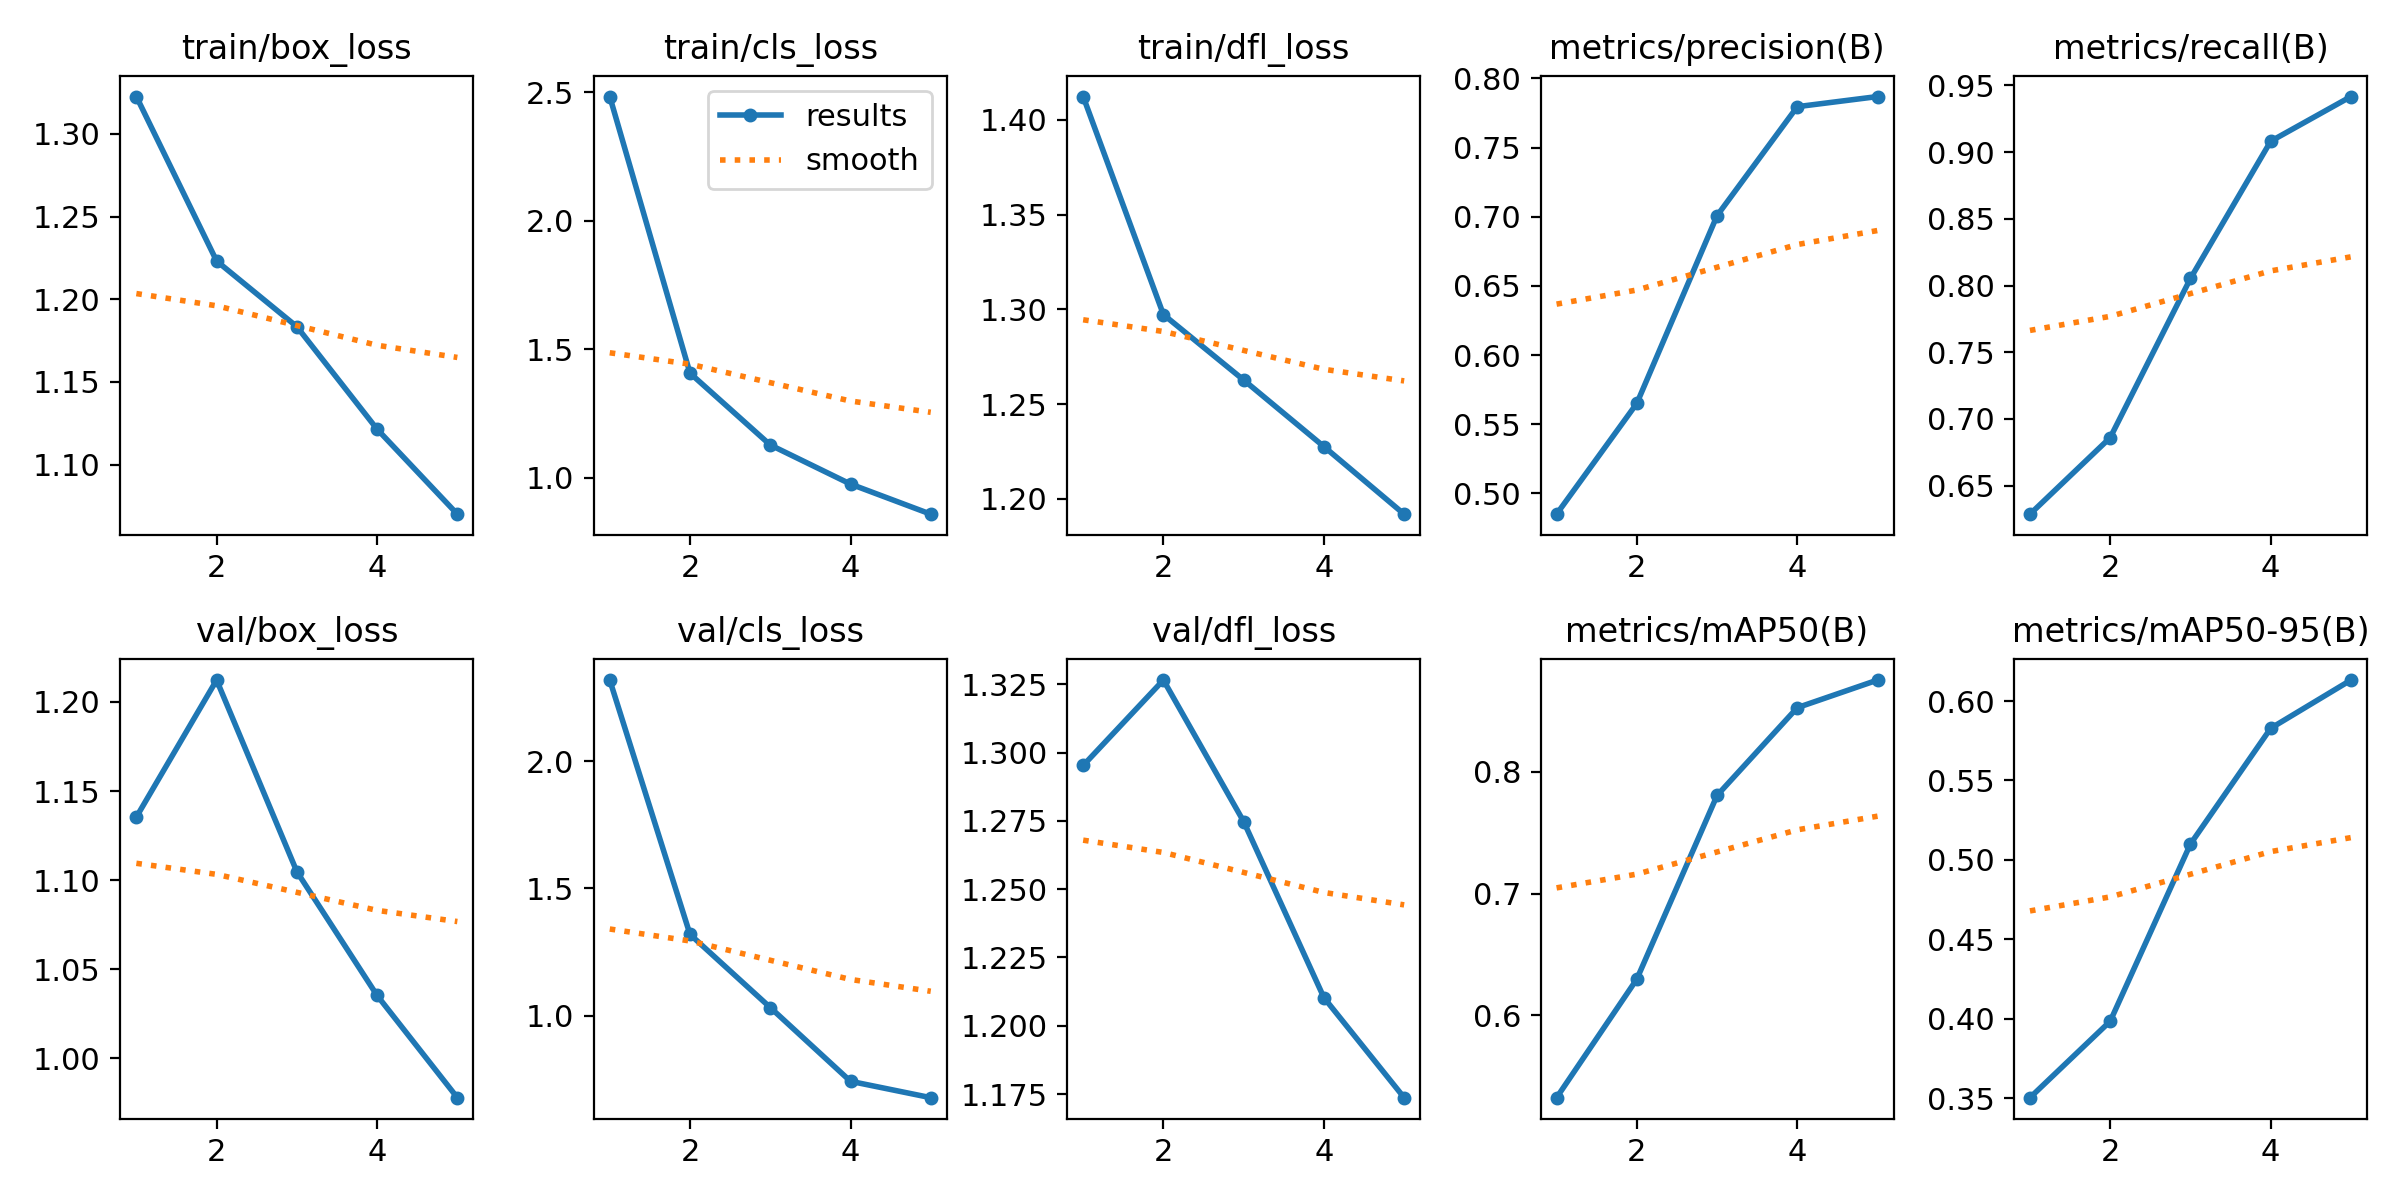

In [8]:
# Display the training results
from IPython.display import Image, display

# Display the training curve
results_image = "/content/YoloRuns/pig_yolo_v9_test_1/results.png"
display(Image(results_image))


In [9]:
from ultralytics import YOLO

# Load the trained model (best weights)
trained_model = YOLO("/content/YoloRuns/pig_yolo_v9_test_1/weights/best.pt")

# Evaluate the model on validation set
metrics = trained_model.val()  # This will automatically use the validation set specified in your YAML file

# # Display evaluation metrics
# print(f"Precision: {metrics['precision']:.4f}")
# print(f"Recall: {metrics['recall']:.4f}")
# print(f"mAP@0.5: {metrics['map50']:.4f}")
# print(f"mAP@0.5:0.95: {metrics['map']:.4f}")


Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9c summary (fused): 156 layers, 25,325,416 parameters, 0 gradients, 102.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3509.0±823.4 MB/s, size: 327.9 KB)


val: Scanning /content/PigDataset/labels.cache... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]


                   all        600       3586      0.787      0.941      0.875      0.613
                 pig_0        515        515      0.852      0.994      0.956      0.663
                 pig_1        497        497      0.827      0.931      0.875       0.63
                 pig_2        306        306      0.774      0.886      0.852      0.526
                 pig_3        507        507      0.827      0.972      0.922      0.643
                 pig_4        432        432      0.707      0.984      0.824      0.607
                 pig_5        475        475      0.847      0.855      0.882      0.636
                 pig_6        365        365      0.655      0.912      0.801      0.534
                 pig_7        489        489      0.805      0.997      0.891      0.667
Speed: 0.5ms preprocess, 18.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


In [11]:
# Display key metrics
# Access metrics using the methods provided by the metrics object
print(f"Precision: {metrics.box.mp:.4f}") # Using metrics.box.mp for mean precision
print(f"Recall: {metrics.box.mr:.4f}")   # Using metrics.box.mr for mean recall
print(f"mAP@0.5: {metrics.box.map50:.4f}") # Using metrics.box.map50 for mAP@0.5
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}") # Using metrics.box.map for mAP@0.5:0.95

Precision: 0.7868
Recall: 0.9414
mAP@0.5: 0.8753
mAP@0.5:0.95: 0.6132


In [12]:
# Use the trained model for inference on a test video
test_video = "/content/drive/MyDrive/EdinburghPig/000002/color.mp4"  # Your test video
results = trained_model.track(
    source=test_video,     # Path to the test video
    conf=0.25,             # Confidence threshold
    iou=0.45,              # IOU threshold
    show=True,             # Display video
    save=True,             # Save results
    save_txt=True,         # Save detection results as text files
    save_conf=True,        # Save confidence scores
    save_crop=False,       # Save cropped detections
    tracker="bytetrack.yaml"  # Use ByteTrack for multi-object tracking
)

# Display the saved result video
# from IPython.display import Video
# result_video = "/content/drive/MyDrive/YoloRuns/pig_yolo_v9_test_1/track.mp4"
# Video(result_video, embed=True)


requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.7s, installed 1 package: ['lap>=0.5.12']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1800) /content/drive/MyDrive/Ed

In [13]:
!cp /content/runs/detect/track/color.avi /content/drive/MyDrive/EdinburghPig

In [20]:
import motmetrics as mm
import os

# Initialize the metric accumulator
acc = mm.MOTAccumulator(auto_id=True)

# Path to the tracking results (YOLO tracking results are stored in txt files)
tracking_results_dir = "/content/runs/detect/track/labels"  # Change to your tracking folder

# Function to parse tracking results
def parse_tracking_results(tracking_results_dir):
    frame_data = {}

    for file in os.listdir(tracking_results_dir):
        if file.endswith(".txt"):
            frame_number = int(file.split(".")[0].split("_")[-1])
            frame_data[frame_number] = []

            with open(os.path.join(tracking_results_dir, file), "r") as f:
                for line in f.readlines():
                    data = line.strip().split()
                    track_id = int(data[0])
                    frame_data[frame_number].append(track_id)

    return frame_data

# Parse tracking results
tracking_data = parse_tracking_results(tracking_results_dir)

# Check if tracking data is empty
if len(tracking_data) == 0:
    print("No tracking data found. Please check the tracking directory.")
else:
    # Generate ground truth and predictions
    previous_frame_tracks = {}
    fragmentation = 0

    for frame, track_ids in tracking_data.items():
        gt_ids = list(previous_frame_tracks.keys())
        pred_ids = track_ids

        # Calculate distances (zero because we are only tracking identity)
        distances = [[0] * len(pred_ids) for _ in gt_ids] if gt_ids else []

        # Update MOT accumulator
        acc.update(
            gt_ids,                 # Ground Truth IDs
            pred_ids,               # Predicted IDs
            distances               # Zero distances (identity match)
        )

        # Track continuity for fragmentation
        for track_id in pred_ids:
            if track_id not in previous_frame_tracks:
                previous_frame_tracks[track_id] = frame
            else:
                if frame - previous_frame_tracks[track_id] > 1:  # Fragmentation occurs
                    fragmentation += 1
                previous_frame_tracks[track_id] = frame

    # Calculate MOTA and IDF1 using MOTMetrics
    mh = mm.metrics.create()
    summary = mh.compute(
        acc,
        metrics=['mota', 'idf1', 'idp', 'idr', 'num_switches'],
        name='Tracking'
    )

    # Add Fragmentation to the summary
    summary['Fragmentation'] = fragmentation

    # Display the results
    print("\n================ Tracking Metrics ================")
    print(summary)



================ Tracking Metrics ================
              mota      idf1       idp       idr  num_switches  Fragmentation
Tracking  0.882279  0.954811  1.016304  0.914038           403           6552


In [ ]:

# # ================================
# # Step 7: Display Results
# # ================================
# from IPython.display import Video

# result_video = "/content/YoloRuns/pig_yolo_v9_test_14/color.avi"
# Video(result_video, embed=True)